##  Lab 5: Applications of Bitplane Decomposition
#### Rina Ahmetaj
#### CSCI 39534

In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

In [ ]:
"""
  method to turn image into binary image (For question 1 & 2)
  Args:
    numpy array: image with pixels as integers
  Returns:
    numpy array: image with bit string values
"""
def create_binary_image(image):
  binary_image = np.array(image).astype(str)
  for i in range(image.shape[0]):
   for j in range(image.shape[1]):
    binary_image[i][j] = bin(image[i][j])[2:]
  return binary_image


"""
  method to create bit planes (For question 1 part 1)
  Args:
    int: number of bit planes (8 bit planes is the choice if no number is given)
    numpy array: image with pixels as binary number (string dtype)
  Returns:
    List: list of bit planes, each bit plane is a numpy array of integers
"""
def create_bit_planes(image, num_bit_planes = 8):
  new_image = np.char.array(np.copy(image))
  bit_planes = []

  for i in range(image.shape[0]):
    for j in range(image.shape[1]):
      new_image[i][j] = image[i][j].zfill(num_bit_planes) #using zfill (padding) to avoid string values such as ' ' when bit strings aren't 8 bits long.
      new_image[i][j] = new_image[i][j][::-1] #reversing bits

  for k in range(num_bit_planes):
    plane = np.empty((image.shape[0], image.shape[1]), dtype = str)
    for i in range(image.shape[0]):
      for j in range(image.shape[1]):
        plane[i][j] = new_image[i][j][k:k+1] #slice string
    bit_planes.append(plane)

  for i in range(len(bit_planes)): #changing type from string to int
   if np.any(bit_planes[i]!= ''):
    bit_planes[i] = bit_planes[i].astype(int)

  return bit_planes


"""
  method plots bit planes
  Args:
    List: list of all bit planes, each bit plane is a numpy array
"""
def plot_bit_planes(bit_planes):
  rows, cols = 2, 4
  fig_size, axes = plt.subplots(2, 4, figsize = (10, 5))
  for i in range(rows):
    for j in range(cols):
      axes[i][j].imshow(bit_planes[i * 4 + j], cmap = 'gray')
      axes[i][j].axis('off')
      axes[i][j].set_title(f'Bit Plane{i * 4 + j}')
  plt.show()


"""method to perform erosion, the purpose is the reduce noise and separate regions for easier component labelling.
   Args:
       numpy array: image
       numpy array: structuring element (kernel)
   Returns:
       numpy array: eroded image
"""
def erosion(image, struct_element = np.ones((3, 3))):
  eroded_image = np.zeros_like(image)

  for i in range(1, image.shape[0] - 1):
    for j in range(1, image.shape[1] - 1):
      region = image[i - 1:i + 2, j - 1:j + 2]
      if np.all(region == struct_element):
        eroded_image[i][j] = 1
  return eroded_image


"""
method to perform dilaton, the purpose is to pass the eroded image and remove any noise to make it clearer for component labelling
  Args:
    numpy array: image
    numpy array: structuring element (kernel)
  Returns:
    numpy array: dilated image
"""
def dilation(image, struct_element = np.ones((3, 3))):
  dilated_image = np.zeros_like(image)
  for i in range(1, image.shape[0] - 1):
   for j in range(1, image.shape[1] - 1):
      region = image[i - 1:i + 2, j - 1:j + 2]
      if np.any(region == struct_element):
        dilated_image[i][j] = 1
  return dilated_image


"""
  method to remove noise using median filter
  Args:
    numpy array: image
  Returns:
    numpy array: denoised image
"""
def median_filter(image):
  window_size = 3 # 3x3 window
  median_image = np.zeros(image.shape)
  for i in range(1, image.shape[0] - 1):
    for j in range(1, image.shape[1] - 1):
      window = image[i-1:i+2, j-1:j+2]
      median = np.median(window)
      median_image[i][j] = median
  return median_image


"""
method to find root when two labels in CCL are not equal to each other
  Args:
     int: label
     dict: equivalence table
  Returns:
     int: root label
"""
def find_root(label, equivalence):
    while label != equivalence[label]:
        label = equivalence[label]
    return label


"""
method to update a new object is encountered in CCL
 Args:
   int: label
 Returns:
   int: new label
"""
def update_label(n):
    return np.clip(n + 1, 0, 255)


"""
method to perform connected component labelling to extract tumor region from MRI scan (region has to be be separated from other areas)
 Args:
   numpy array: image
 Retuns:
   numpy array: labelled image
"""
def ccl(image):
  equivalence = {}
  label = 1
  labelled_image = np.zeros_like(image, dtype=np.uint8)

  for i in range(1, image.shape[0] - 1):
      for j in range(1, image.shape[1] - 1):
          if  image[i, j] == 1:
              left_neighbor = labelled_image[i, j - 1]
              top_neighbor = labelled_image[i - 1, j]

              if left_neighbor == 0 and top_neighbor == 0:
                  label = int(update_label(label)) #new label
                  labelled_image[i, j] = label
                  equivalence[label] = label

              #case when two neighbors are of different numbers is encountered
              elif left_neighbor != 0 and top_neighbor != 0 and top_neighbor != left_neighbor:
                labelled_image[i, j] = min(left_neighbor, top_neighbor)
                root1 = find_root(left_neighbor, equivalence)
                root2 = find_root(top_neighbor, equivalence)
                if root1 != root2:
                      if root1 < root2:
                          equivalence[root2] = root1
                      else:
                          equivalence[root1] = root2

              else:
                  labelled_image[i, j] = max(left_neighbor, top_neighbor)

 #second pass to set labels within a region to one label i.e tumor region
  for i in range(labelled_image.shape[0]):
      for j in range(labelled_image.shape[1]):
          if labelled_image[i, j] != 0:
              labelled_image[i, j] = find_root(labelled_image[i, j], equivalence)
  return labelled_image



"""
method to display 2 images (before and after a filter is applied)
Args:
  numpy array: image before filter
  numpy array: image after filter
"""
def plot_image(image1, image2):
  fig, axes = plt.subplots(1, 2, figsize = (7, 2))
  axes[0].imshow(image1, cmap = 'gray')
  axes[0].axis('off')
  axes[0].set_title('Image Before')
  axes[1].imshow(image2, cmap = 'gray')
  axes[1].axis('off')
  axes[1].set_title('Image After Filter')
  plt.show()


"""
method to convert a sentence into binary code
 Args:
   string: sentence
 Returns:
   List: each word in sentence is a string of bits
   int: number of words in the sentence
"""
def encode_binary_sentence(sentence):
   words = sentence.split()
   encoded_sentence = []

   for word in words:
        bin_word = ''
        for char in word:
            bin_char = bin(ord(char))[2:].zfill(8)  # remove '0b', pad to 8 bits
            reversed_bin_char = bin_char[::-1]      # reverse bits
            bin_word += reversed_bin_char
        encoded_sentence.append((bin_word))

   return encoded_sentence, len(words)
# def encode_binary_sentence(sentence): # one version of encoding
#   sentences = sentence.split()
#   encoded_sentence = []
#   for sentence in sentences:
#     chars = []
#     for char in sentence:
#      chars.append(bin(ord(char)))
#     encoded_sentence.append(chars)
#   # second pass
#   for i in range(len(encoded_sentence)):
#     for j in range(len(encoded_sentence[i])):
#       encoded_sentence[i][j] = encoded_sentence[i][j][::-1].zfill(8)
#   return encoded_sentence, len(encoded_sentence)


### Question 1: Image Bitplane Decomposition


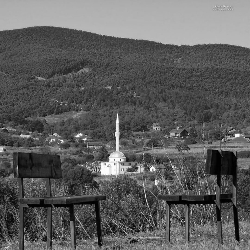

(None, (250, 250))

In [ ]:
# loading and displaying image
nature_im = cv2.imread('nature.png')
grayscale_im = cv2.cvtColor(nature_im, cv2.COLOR_RGB2GRAY)
grayscale_im = cv2.resize(grayscale_im, dsize=(250, 250), interpolation=cv2.INTER_CUBIC)
image_arr = np.array(grayscale_im).astype(int)
cv2_imshow(image_arr), image_arr.shape

In [ ]:
binary_image_1 = create_binary_image(image_arr)
bit_plane_1 = create_bit_planes(binary_image_1, 8)

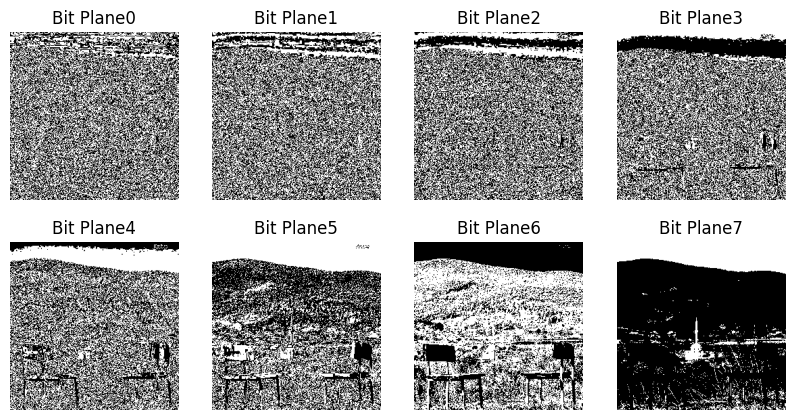

In [ ]:
plot_bit_planes(bit_plane_1)

###Question 2: Noise Removal in OCT Image using Bitplane Decomposition

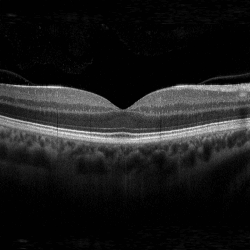

(None, (250, 250))

In [ ]:
#load image
oct = cv2.imread('oct image.png')
oct = cv2.resize(oct, dsize = (250, 250), interpolation=cv2.INTER_CUBIC)
oct_grayscale = cv2.cvtColor(oct, cv2.COLOR_RGB2GRAY)
oct_im = np.array(oct_grayscale).astype(int)
cv2_imshow(oct_im), oct_im.shape

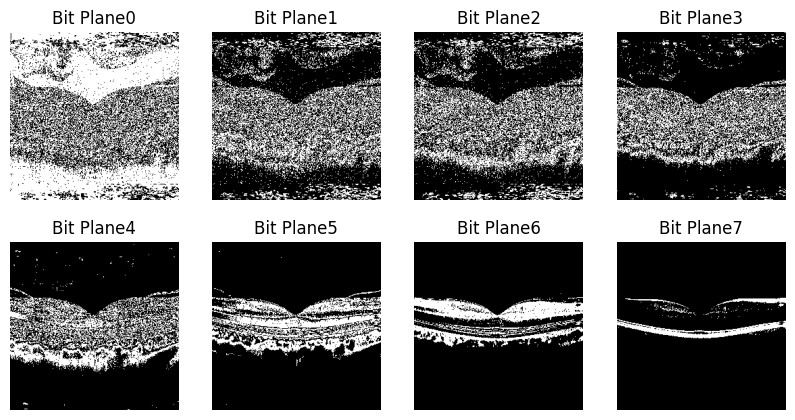

In [ ]:
# decomposing the oct image into binary planes and displaying them
binary_image_2 = create_binary_image(oct_im)
bit_plane_2 = create_bit_planes(binary_image_2, 8)
plot_bit_planes(bit_plane_2)

In [ ]:
# applying median filter to remove noise on bit planes 0 - 4
noisy_bit_planes = []
num_noisy_bit_planes = 5
for i in range(num_noisy_bit_planes):
  noisy_bit_planes.append(median_filter(bit_plane_2[i]))


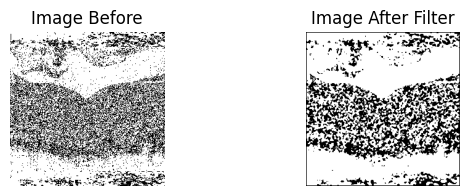

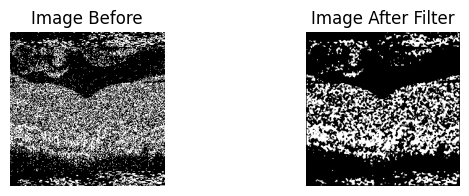

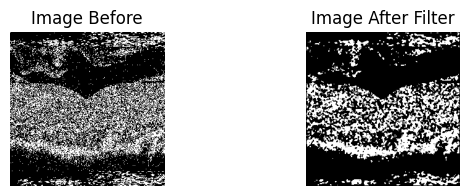

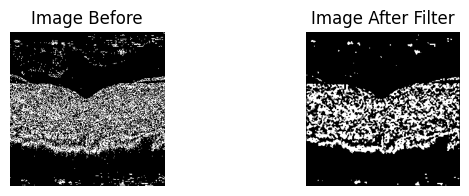

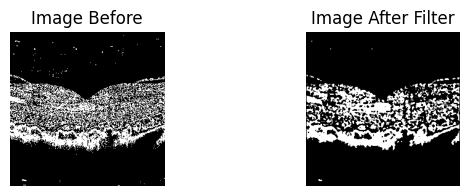

In [ ]:
#plotting noisy images before and after median filter
plot_image(bit_plane_2[0], noisy_bit_planes[0])
plot_image(bit_plane_2[1], noisy_bit_planes[1])
plot_image(bit_plane_2[2], noisy_bit_planes[2])
plot_image(bit_plane_2[3], noisy_bit_planes[3])
plot_image(bit_plane_2[4], noisy_bit_planes[4])

###Question 3: MRI Tumor Segmentation

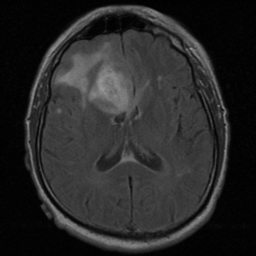

(None, (256, 256))

In [ ]:
mri = cv2.imread('mri.tif')
mri = cv2.cvtColor(mri, cv2.COLOR_RGB2GRAY)
mri_im = np.array(mri).astype(int)
# mri_thresh = np.where(mri_im < 100, 0, 255)
cv2_imshow(mri_im), mri_im.shape

In [ ]:
#decomposing the MRI scan into binary planes
binary_image_3 = create_binary_image(mri_im)
bit_plane_3 = create_bit_planes(binary_image_3, 8)

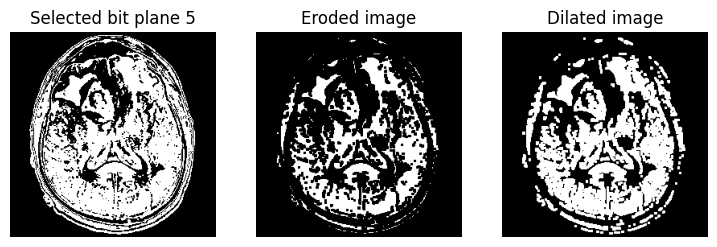

In [ ]:
selected_bit_plane = bit_plane_3[5].astype(np.uint8)
labelled_image = np.zeros_like(selected_bit_plane)
#performing erosion and dilation to clean the image from noise or complicated regions
eroded = erosion(selected_bit_plane)
dilated = dilation(eroded)
fig_size, axes = plt.subplots(1, 3, figsize = (9, 4))
# selected bit plane displayed shows the tumor area is separated from the rest of the white area
axes[0].imshow(selected_bit_plane, cmap = 'gray')
axes[0].set_title('Selected bit plane 5')
axes[0].axis('off')

axes[1].imshow(eroded, cmap = 'gray')
axes[1].set_title('Eroded image')
axes[1].axis('off')

axes[2].imshow(dilated, cmap = 'gray')
axes[2].set_title('Dilated image')
axes[2].axis('off')
plt.show()

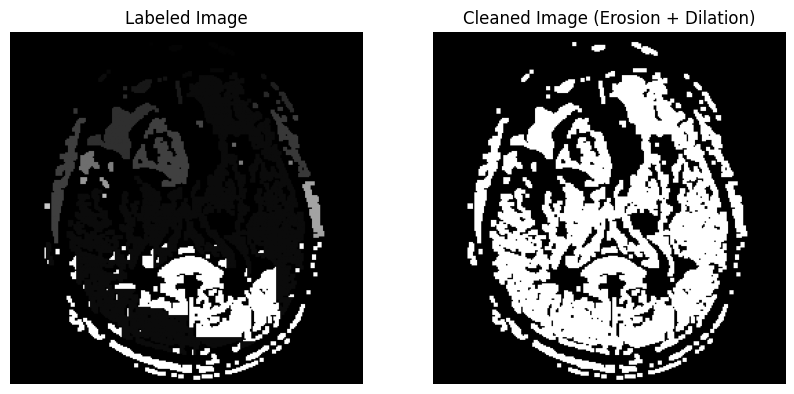

In [ ]:
labelled_image = ccl(dilated)
fig_size, axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].imshow(labelled_image, cmap = 'gray')
axes[0].set_title('Labeled Image')
axes[0].axis('off')
axes[1].imshow(dilated, cmap = 'gray')
axes[1].set_title('Cleaned Image (Erosion + Dilation)')
axes[1].axis('off')
plt.show()

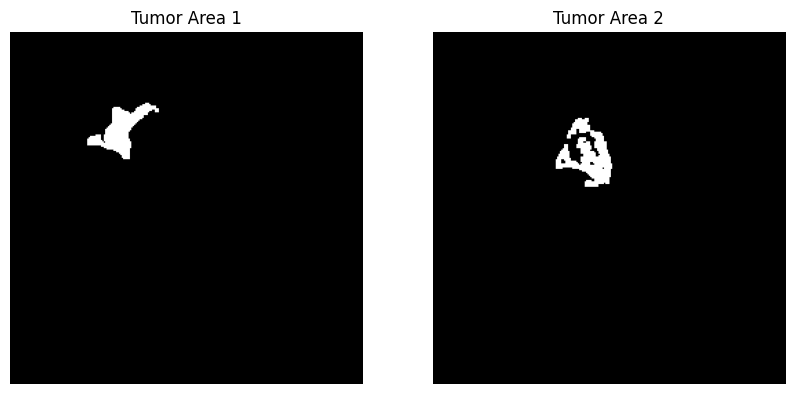

In [ ]:
#extracting brain tumor area
target_areas = []
for label in np.unique(labelled_image):
  if label == 47 or label == 64:
   target_areas.append((np.where(labelled_image == label, 255, 0)))
#displaying images
fig_size, axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].imshow(target_areas[0], cmap = 'gray')
axes[0].set_title('Tumor Area 1')
axes[0].axis('off')
axes[1].imshow(target_areas[1], cmap = 'gray')
axes[1].set_title('Tumor Area 2')
axes[1].axis('off')
plt.show()


####Question 4: Data Hiding using Least Significant Bitplane

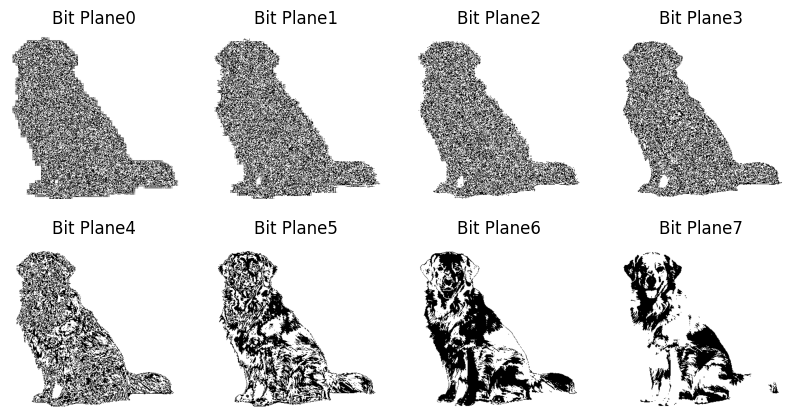

In [ ]:
dog_im = cv2.imread('dog.png')
dog_im = cv2.cvtColor(dog_im, cv2.COLOR_RGB2GRAY)
dog_im_arr = np.array(dog_im).astype(int)
#extracting image into bit planes
binary_image_4 = create_binary_image(dog_im_arr)
bit_plane_4 = create_bit_planes(binary_image_4, 8)

plot_bit_planes(bit_plane_4)

In [ ]:
# writing sentence and then converting it into binary code
dog_sentence  = 'This is a Golden Retriever'
encoded_words, num_words = encode_binary_sentence(dog_sentence)

(np.float64(-0.5), np.float64(330.5), np.float64(328.5), np.float64(-0.5))

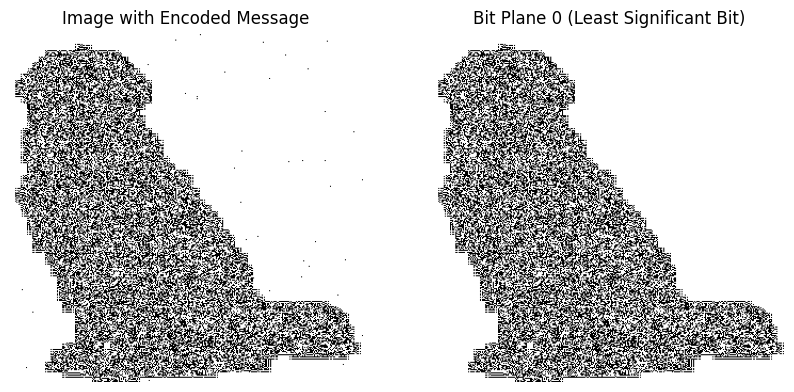

In [ ]:
LSB_plane = bit_plane_4[0]
shape = LSB_plane.shape
encoded_image = np.copy(LSB_plane)
sentence = ''.join(encoded_words) #encoded_image is a string list, turning it into a single string

for bit in sentence:
    #choose  a random row and column within the bit plane
    random_row = np.random.randint(0, shape[0])
    random_col = np.random.randint(0, shape[1])
    # assign one of the words to it
    #print(bit)
    encoded_image[random_row][random_col] = bit

fig_size, axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].imshow(encoded_image * 255, cmap = 'gray')
axes[0].set_title('Image with Encoded Message')
axes[0].axis('off')
axes[1].imshow(LSB_plane, cmap = 'gray')
axes[1].set_title('Bit Plane 0 (Least Significant Bit)')
axes[1].axis('off')
# # plt.imshow(encoded_image * 255, cmap= 'gray')